In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import os

from sklearn.metrics import r2_score

from NMR_model import DynamicNMRRegressor, DynamicNMRDataset
from NMR_preproc_methods import parse_directory, parse_data_file, splitSamples, split_data

In [2]:
# Парсим каждый файл и добавляем образцы в общий массив

file_path = "./kozlopan_ml100.txt" # ФАЙЛ ОБУЧАЮЩЕЙ ВЫБОРКИ
parsed_data = parse_data_file(file_path)

# ПРОВЕРКА
for i, sample in enumerate(parsed_data[:2]):
    print(f"Sample {i}:")
    print(f"Yi: {sample.get('Yi', [])}")
    for key in sorted(sample.keys()):
        if key.startswith("X["):
            print(f"{key}: first 5 values - {sample[key][:5]}")
    print()

# print(parsed_data[0]["X[0]"])
print(len(parsed_data)) # кол-во сигналов
print(len(parsed_data[0]["Yi"])) # кол-во целевых
print(len(parsed_data[0]["X[0]"])) # длина х0
print(len(parsed_data[0]["X[1]"])) # длина х1
print(len(parsed_data[0])-1) # кол-во х

Sample 0:
Yi: [0.0, 0.0]
X[0]: first 5 values - [1.0, 0.9998269081, 0.9993076921, 0.9984430671, 0.9972337484]
X[1]: first 5 values - [0.0, 0.2211992145, 0.3934693336, 0.5276334286, 0.6321205497]

Sample 1:
Yi: [1.0, 0.25]
X[0]: first 5 values - [1.0, 0.9987791181, 0.9951239824, 0.9890571237, 0.9806157351]
X[1]: first 5 values - [0.0, 0.07688365132, 0.1478562057, 0.2133721411, 0.2738509774]

100
2
400
60
2


Для теста парсим набор файлов, сгенерированных с шумом или без

In [3]:
parsed_data_for_test = parse_directory(directory_path="./SygnalsWithoutNoise") # Для тестов
print(len(parsed_data_for_test)) # кол-во сигналов в тестовой выборке

16


Но лучше иметь больше сигналов для теста, поэтому просто разделим большую обучающую базу на train/test

In [4]:
train_data, test_data = split_data(parsed_data, train_ratio=0.85, shuffle=True, random_seed=42)

print(f"Всего образцов: {len(parsed_data)}")
print(f"Обучающая выборка: {len(train_data)} образцов")
print(f"Тестовая выборка: {len(test_data)} образцов")

Всего образцов: 100
Обучающая выборка: 85 образцов
Тестовая выборка: 15 образцов


In [5]:
# x_train, y_train = splitSamples(parsed_data)
# x_test, y_test = splitSamples(parsed_data_for_test)
x_train, y_train = splitSamples(train_data)
x_test, y_test = splitSamples(test_data)

DATASET & MODEL

In [6]:
batch_size = 32
train_dataset = DynamicNMRDataset(*x_train, y=y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DynamicNMRDataset(*x_test, y=y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Гибкость: Модель адаптируется к любому количеству экспериментов (M) и целей (N).

Масштабируемость: Можно добавлять новые типы сигналов без изменения кода.

Автоматическая адаптация: Размеры слоев вычисляются динамически.


In [7]:
input_dims = [len(x[0]) for x in x_train]  # Длины каждого X[i]
num_targets = len(y_train[0])  # Количество целевых переменных (Yi)

assert input_dims == [len(x[0]) for x in x_test] and num_targets == len(y_test[0]), "Несоответствие размеров train/test"
print(input_dims, num_targets)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)

model = DynamicNMRRegressor(input_dims, num_targets)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

[400, 60] 2
Используемое устройство: cpu


Цикл обучения

In [8]:
best_test_loss = float('inf')
best_r2 = -float('inf')
best_epoch = 0
patience = 10  # n эпох без улучшения перед остановкой
counter = 0
r2_threshold = 0.8

history = {
    'train_loss': [],
    'test_loss': [],
    'r2': [],
    'best_epoch_data': None
}

for epoch in range(250):
    model.train()
    train_running_loss = 0.0
    
    for batch in train_dataloader:
        *x_batch, y_batch = batch
        x_batch = [x.to(device) for x in x_batch]
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(*x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
    
    # =========

    model.eval()
    test_running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            *x_batch, y_batch = batch
            x_batch = [x.to(device) for x in x_batch]
            y_batch = y_batch.to(device)
            
            outputs = model(*x_batch)
            loss = criterion(outputs, y_batch)
            test_running_loss += loss.item()
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    train_loss = train_running_loss / len(train_dataloader)
    test_loss = test_running_loss / len(test_dataloader)
    r2 = r2_score(all_targets, all_preds)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['r2'].append(r2)
    
    print(f"Epoch {epoch + 1}")
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | R² Score: {r2:.4f}")
    
    # ========= Early Stopping =========
    if test_loss < best_test_loss and r2 >= r2_threshold:  # test_loss главный параметр, R² threshold
        best_test_loss = test_loss
        best_r2 = r2
        best_epoch = epoch
        counter = 0
        
        history['best_epoch_data'] = {
            'predictions': all_preds,
            'targets': all_targets,
            'epoch': epoch
        }

        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience and r2 >= r2_threshold:
            print(f"Early stopping at epoch {epoch + 1}")
            print(f"Best epoch: {best_epoch + 1} | Best Test Loss: {best_test_loss:.4f} | Best R²: {best_r2:.4f}")
            # break убрал, он не нужен
    
    print("-" * 50)
print(f"Best epoch: {best_epoch + 1} | Best Test Loss: {best_test_loss:.4f} | Best R²: {best_r2:.4f}")

model.load_state_dict(torch.load('best_model.pth', weights_only=True))

Epoch 1
Train Loss: 0.0920 | Test Loss: 0.0736 | R² Score: -0.8363
--------------------------------------------------
Epoch 2
Train Loss: 0.0809 | Test Loss: 0.0567 | R² Score: -0.5511
--------------------------------------------------
Epoch 3
Train Loss: 0.0487 | Test Loss: 0.0586 | R² Score: -1.0042
--------------------------------------------------
Epoch 4
Train Loss: 0.0509 | Test Loss: 0.0694 | R² Score: -0.4030
--------------------------------------------------
Epoch 5
Train Loss: 0.0522 | Test Loss: 0.0486 | R² Score: -0.1286
--------------------------------------------------
Epoch 6
Train Loss: 0.0360 | Test Loss: 0.0333 | R² Score: 0.0132
--------------------------------------------------
Epoch 7
Train Loss: 0.0339 | Test Loss: 0.0313 | R² Score: -0.1574
--------------------------------------------------
Epoch 8
Train Loss: 0.0355 | Test Loss: 0.0254 | R² Score: -0.0952
--------------------------------------------------
Epoch 9
Train Loss: 0.0205 | Test Loss: 0.0258 | R² Score

<All keys matched successfully>

ВИЗУАЛИЗАЦИЯ

In [20]:
def getErrorsMaxMean(errors):
    print("МАКСИМАЛЬНОЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ =", max(errors))
    print("СРЕДНЕЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ =", np.sum(np.abs(errors)) / len(errors)) 

ДЛЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ 0
МАКСИМАЛЬНОЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.019475043
СРЕДНЕЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.005277326206366221
ДЛЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ 1
МАКСИМАЛЬНОЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.048835352
СРЕДНЕЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.027869009971618654


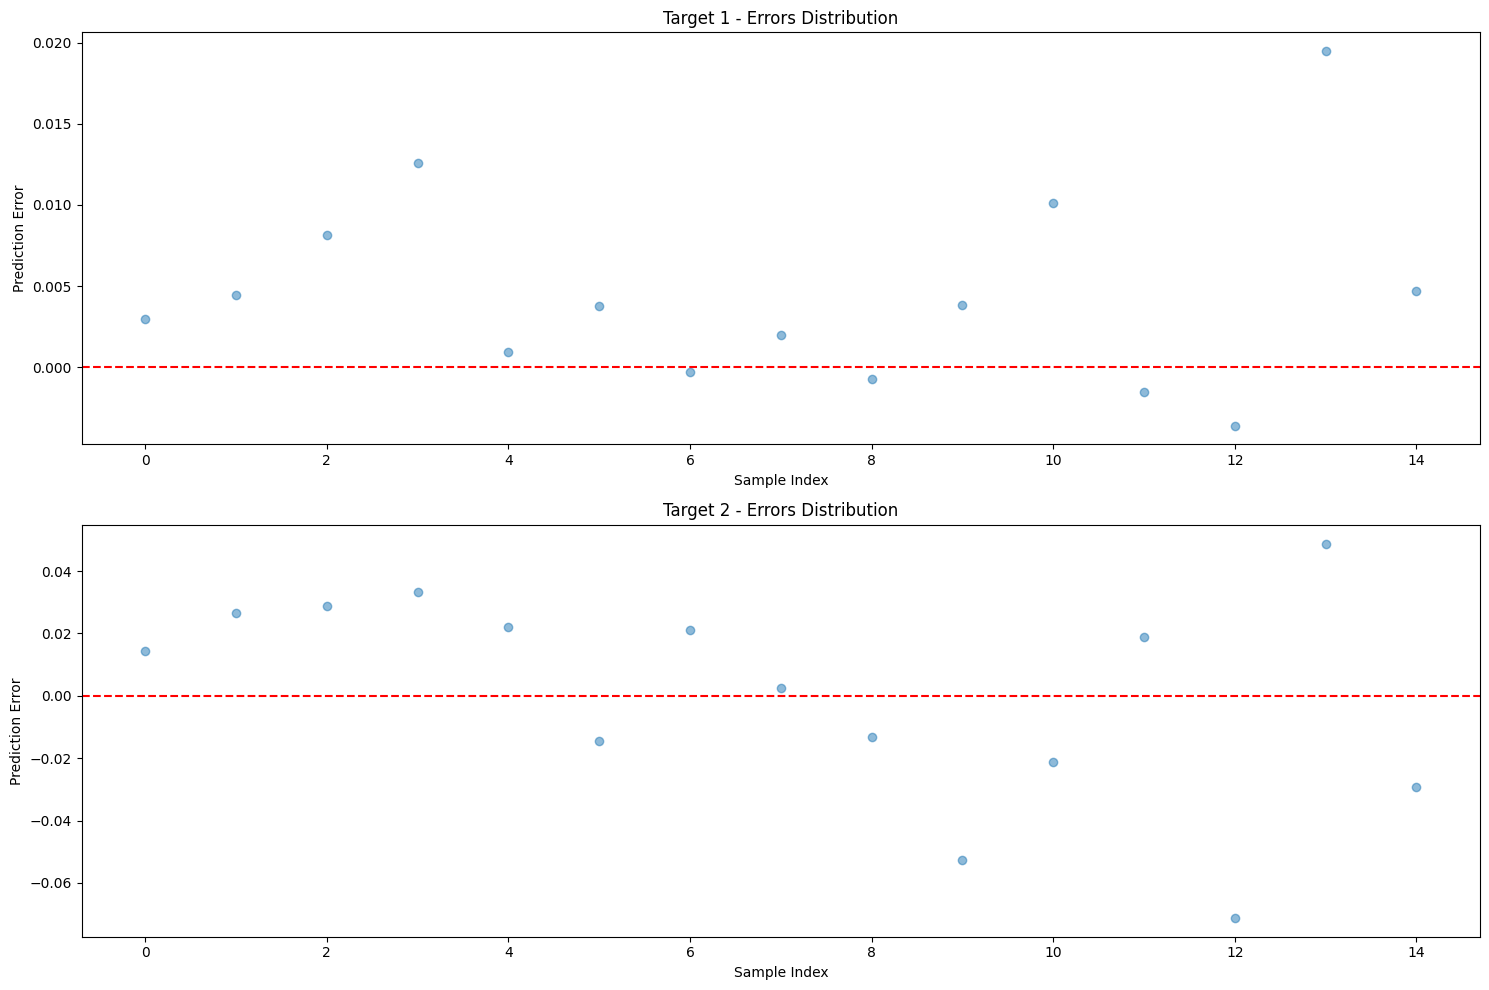

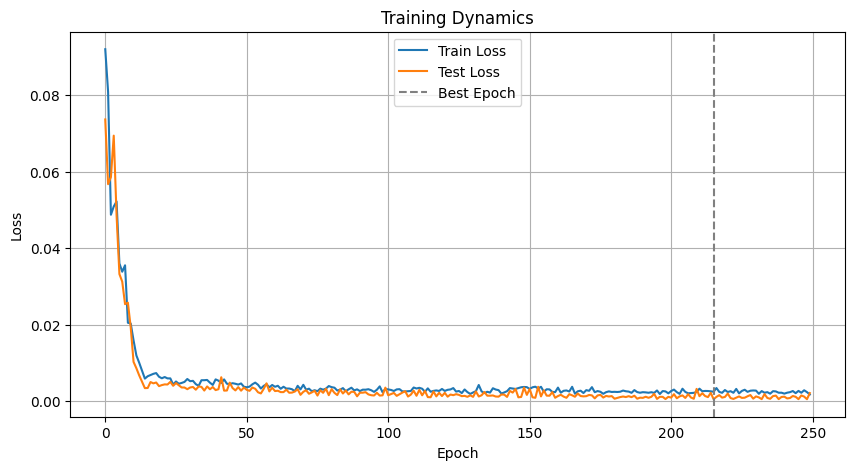

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. График ошибок для каждой целевой переменной
best_data = history['best_epoch_data']
num_targets = best_data['targets'].shape[1]  # N целевых переменных

plt.figure(figsize=(15, 5 * num_targets))
for i in range(num_targets):
    plt.subplot(num_targets, 1, i+1)
    errors = best_data['predictions'][:, i] - best_data['targets'][:, i]
    print("ДЛЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ", i)
    getErrorsMaxMean(errors)
    plt.scatter(range(len(errors)), errors, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f'Target {i+1} - Errors Distribution')
    plt.xlabel('Sample Index')
    plt.ylabel('Prediction Error')
plt.tight_layout()
plt.savefig('target_errors.png')
plt.show()

# 2. График динамики потерь
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.axvline(x=best_epoch, color='gray', linestyle='--', label='Best Epoch')
plt.title('Training Dynamics')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_dynamics.png')
plt.show()

# МАКСИМАЛЬНОЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.42214468
# СРЕДНЕЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.15238440036773682
# ДЛЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ 1
# МАКСИМАЛЬНОЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.14524601
# СРЕДНЕЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.1370295286178589

# noise( model 0.003 0.003, test 0.005 0.001)
# ДЛЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ 0
# МАКСИМАЛЬНОЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.5564435
# СРЕДНЕЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.14632920920848846
# ДЛЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ 1
# МАКСИМАЛЬНОЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.13492721
# СРЕДНЕЕ ОТКЛОНЕНИЕ ОТ ИСТИНОГО ЗНАЧЕНИЯ = 0.15614362061023712

SAVE MODEL STATE TO FILE

In [10]:
# torch.save(model, 'model.pth')
torch.save(model.state_dict(), 'model_weights_100.pth')